In [142]:
import os
import itertools
import numpy as np
import pandas as pd
import networkx as nx
from distinctipy import distinctipy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm

from shapely.geometry import Polygon

from importlib import reload
import tilings
tilings = reload(tilings)
from tilings import Tiling, TilingGroup

import CrossingModel
CrossingModel = reload(CrossingModel)
from CrossingModel import CrossingModel
%matplotlib inline

In [143]:
def plot_tiling(t, ax=None, color='k', linestyle='--', linewidth=1):
    if not ax:
        ax = plt.figure().gca()
        
    for e in t.edges[0]:
        ax.axvline(e, color=color, linestyle=linestyle, linewidth=linewidth)
    for e in t.edges[1]:
        ax.axhline(e, color=color, linestyle=linestyle, linewidth=linewidth)
        
    ax.set_xlim(t.limits[0])
    ax.set_ylim(t.limits[1])

In [144]:
def plot_state(s, ax=None, fig = None, color='r', marker='o', markersize=8):
    axs = [ax]
    if fig is not None:
        axs = fig.get_axes()
    elif not ax:
        axs = [plt.figure().gca()]
    axs[0].plot(s[0], s[1], color=color, marker=marker, markersize=markersize)

In [145]:
def bounds_from_dims(t, dims):
    if dims[0] == t.ntiles[0]-1:
        right = t.limits[0][1]
    else:
        right = t.edges[0][dims[0]]
    if dims[0] == 0:
        left = t.limits[0][0]
    else:
        left = t.edges[0][dims[0]-1]

    if dims[1] == t.ntiles[1]-1:
        top = t.limits[1][1]
    else:
        top = t.edges[1][dims[1]]
    if dims[1] == 0:
        bottom = t.limits[1][0]
    else:
        bottom = t.edges[1][dims[1]-1]

    bounds = (left, bottom, right, top)

    return bounds

def state_bounds(s, t):
    dims = t.tile_dims(s)
    bounds = bounds_from_dims(t, dims)
    return bounds


def feature_bounds(f, t):
    dims = t.dims_from_feature(f)
    bounds = bounds_from_dims(t, dims)
    return bounds

In [146]:
def highlight_tile(s, t, ax=None, color='r', alpha=0.3):
    if not ax:
        ax = plt.figure().gca()
    left, bottom, right, top = state_tile(s, t)
    r = Rectangle((left, bottom), right-left, top-bottom, color=color, alpha=alpha)
    ax.add_patch(r)

In [147]:
def plot_tiling_group(tg, ax=None, linewidth=0.5, colors=None):
    if not ax:
        ax = plt.figure().gca()
    if not colors:
        colors = distinctipy.get_colors(tg.ntilings)
    
    for i, t in enumerate(tg.tilings):
        plot_tiling(t, ax=ax, color=colors[i], linestyle='-', linewidth=linewidth)

In [148]:
def bounds_intersection(a, b):
    x1 = max(min(a[0], a[2]), min(b[0], b[2]))
    y1 = max(min(a[1], a[3]), min(b[1], b[3]))
    x2 = min(max(a[0], a[2]), max(b[0], b[2]))
    y2 = min(max(a[1], a[3]), max(b[1], b[3]))
    if x1<x2 and y1<y2:
        return (x1, y1, x2, y2)

In [149]:
def highlight_tiling_group(tg, s = None, f = None, ax=None, linewidth=0.5, colors=None, alpha=0.3, op = 'union'):
    '''Get tile corresponding to state in each of the tilings in the group. Combine these tiles using the op operation.
    Plot the combined tile
    '''

    if not ax:
        ax = plt.figure().gca()
    if not colors:
        colors = distinctipy.get_colors(tg.ntilings)

    rects = []
    for i,t in enumerate(tg.tilings):
        if s is not None:
            r_bounds = state_bounds(s, t)
        else:
            fi = tg.decompose_feature(f)[i]
            r_bounds = feature_bounds(fi, t)
        rects.append(r_bounds)

    # Now choose what to plot
    if op == 'union':
        for i, bounds in enumerate(rects):
            r = Rectangle((bounds[0], bounds[1]), bounds[2] - bounds[0], bounds[3] - bounds[1], color=colors[0], alpha=alpha)
            ax.add_patch(r)
    else:
        # Find intersection between rectangles
        bounds = rects[0]
        for b_ in rects:
            bounds = bounds_intersection(bounds, b_)
        # Plot resulting rectanlge
        if bounds is not None:
            r = Rectangle((bounds[0], bounds[1]), bounds[2] - bounds[0], bounds[3] - bounds[1], color=colors[0], alpha=alpha)
            ax.add_patch(r)
        else:
            print(rects)

In [150]:
def unpack_feature_values(features, w = None, N = None):
    values = []
    n_visits = []
    for f in features:
        if w is not None:
            q = np.matmul(f, w)
            values.append(q)
        if N is not None:
            num = np.matmul(f, N) / np.matmul(f,f)
            n_visits.append(num)
    return {'values':values, 'n_visits':n_visits}

In [151]:
def plot_feature_values(tg, features, values, figsize, ax = None, nbins = 10, cmap = 'viridis', alpha = 0.5, op = 'union'):
    
    # Bin values and get colours for each bin
    hist, bin_edges = np.histogram(values, bins = nbins)
    value_colors = cm.get_cmap(name = cmap, lut = len(bin_edges)).colors
    
    if not ax:
        ax = plt.figure(figsize=figsize).gca()
    
    colors = distinctipy.get_colors(tg.ntilings)
    plot_tiling_group(tg, ax=ax, linewidth=0.5, colors=colors)

    for i, f in enumerate(features):
        # Get bin
        bin_ind = np.digitize(values[i], bin_edges) - 1
        c = value_colors[bin_ind][:-1]
        c = tuple(np.append(c, alpha))
        _ = highlight_tiling_group(tg, f=f, ax=ax, colors=[c], op = op)
    return ax

In [152]:
def plot_ped_feature_values(ped, figsize, nbins = 10, cmaps = ['viridis', 'magma'], alpha = 0.5, op = 'union'):
    # Average over actions
    w_av = ped._w.mean(axis = 1)
    N_av = ped._N.mean(axis = 1)
    # Loop through the nodes of the MDP - these are all the states
    features = list(ped._env.road_env._tg.all_features())
    unpacked = unpack_feature_values(features, w = w_av, N = N_av)
    
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=figsize)
    
    ax1 = plot_feature_values(ped._env.road_env._tg, features, unpacked['values'], figsize, ax = ax1, nbins = nbins, cmap = cmaps[0], alpha = alpha, op = op)
    
    ax2 = plot_feature_values(ped._env.road_env._tg, features, unpacked['n_visits'], figsize, ax = ax2, nbins = nbins, cmap = cmaps[1], alpha = alpha, op = op)

    return fig
    

## Initialise road model with single pedestrian

In [153]:
# Road parameters
road_length = 100
road_width = 10
n_lanes = 1
vehicle_flow = 3

# Ped parameters
o = (0,0)
d = (road_length*0.5, road_width)
s = 1.5
b = 0
g = 0.7
a = 0.05

cross_model = CrossingModel(road_length, road_width, vehicle_flow, n_lanes, o, d, g, a, s)

# Get ped and road

ped = cross_model.getPed()
road = cross_model.getRoad()

## Plot tilings for this environment

Also plot the states: pedestrian starting location, destionation and unsignalised crossing

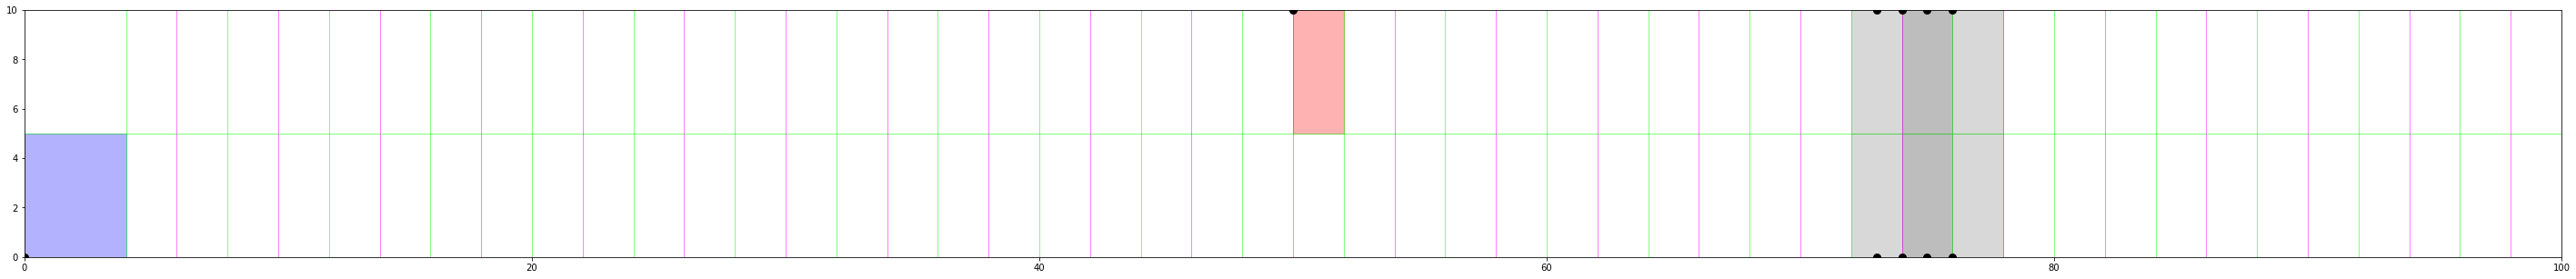

In [154]:
ax = plt.figure(figsize=(road_length*0.5, road_width * 0.5)).gca()
colors = distinctipy.get_colors(ped._env.road_env._tg.ntilings)

plot_tiling_group(ped._env.road_env._tg, ax=ax, linewidth=0.5, colors=colors)

states = [ped._loc, d] + road.getCrossingCoords()
state_colors = ['blue', 'red'] + ['grey']*len(road.getCrossingCoords())
for i, s in enumerate(states):
    c = state_colors[i]
    highlight_tiling_group(ped._env.road_env._tg, s=s, ax=ax, colors=[c], op = 'intersection') 
    plot_state(s, ax=ax, color='k')

## Train agent and plot resulting value function

* 1 training step
* 1 planning step per training step

In [155]:
training_steps = 2
planning_steps = 1
for i in range(training_steps):
	ped.dyna_step(nplanningsteps=planning_steps)

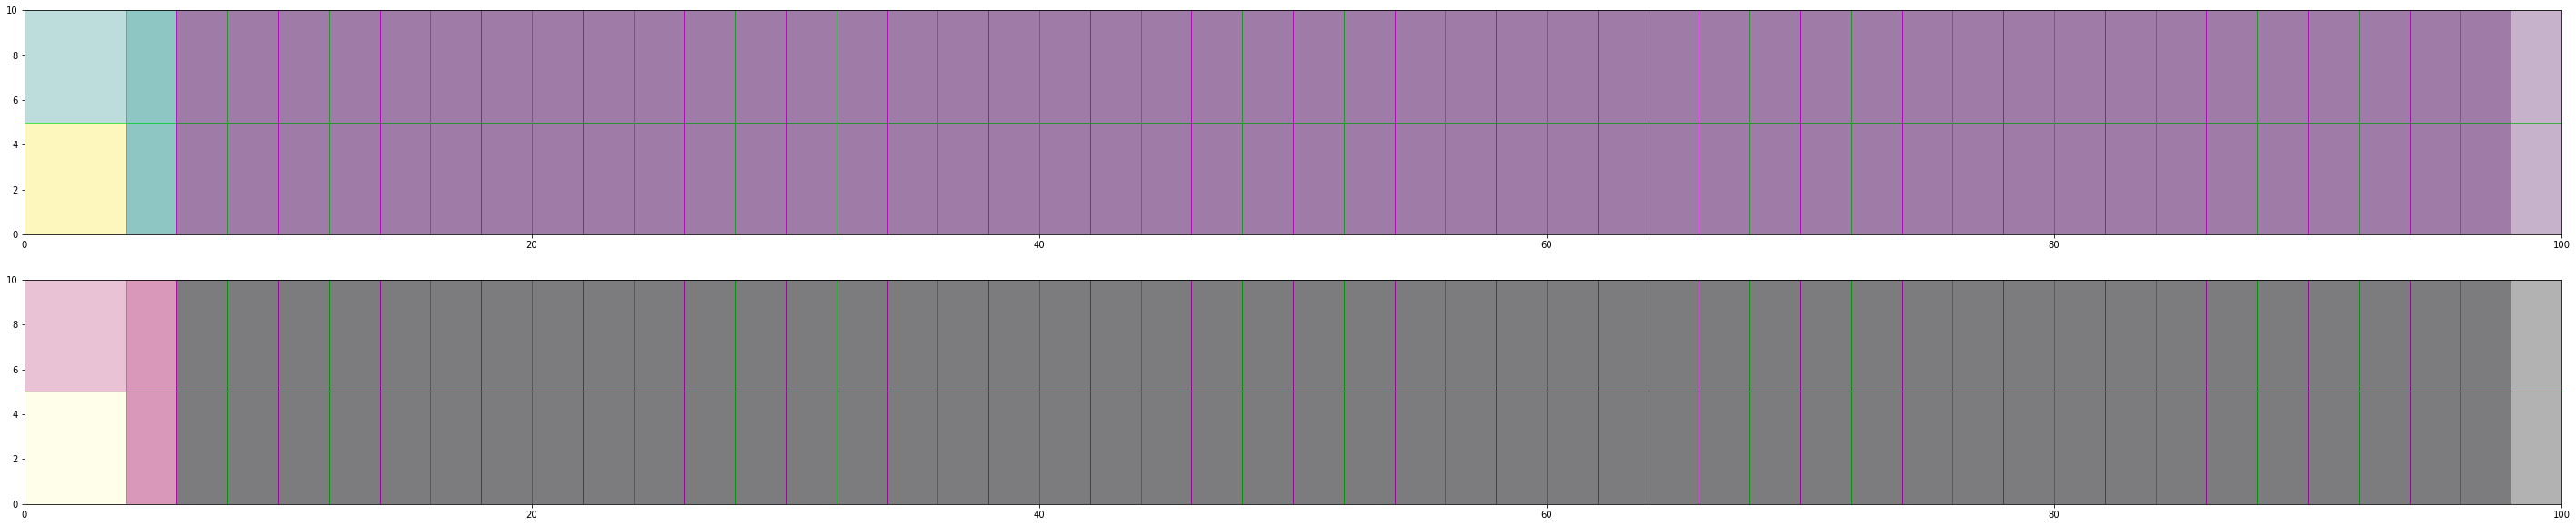

In [156]:
figsize = (road_length*0.5, road_width)
fig = plot_ped_feature_values(ped, figsize, nbins = 10, cmaps = ['viridis', 'magma'], alpha = 0.5, op = 'intersection')

* train for several epochs
* 1 planning step for dyna step

In [157]:
nepochs = 100
planning_steps = 1
while ped._nepochs <nepochs:
	ped.train(nplanningsteps=planning_steps)

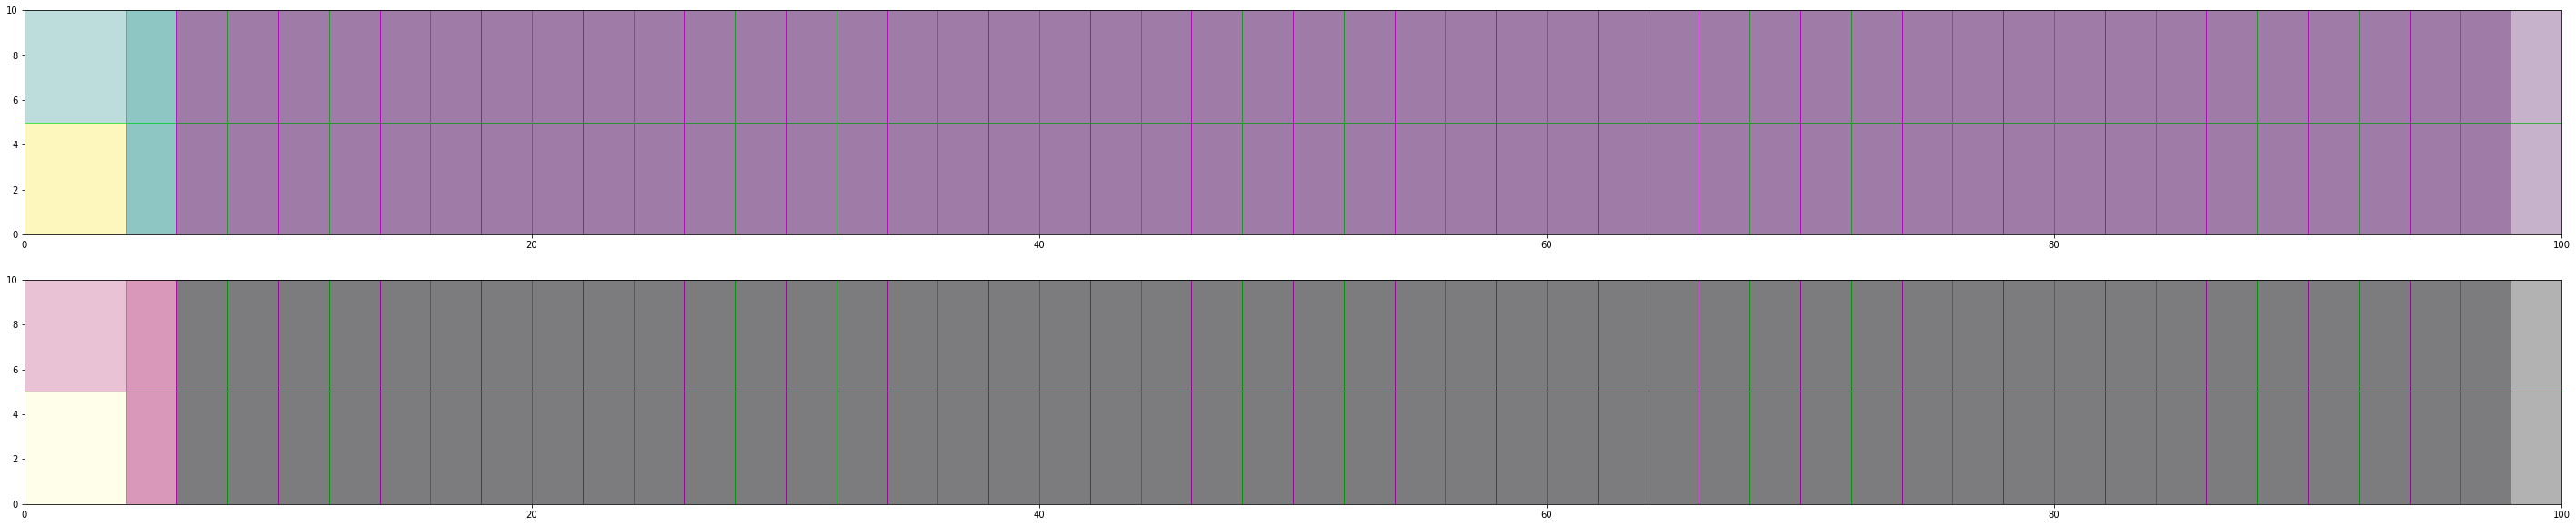

In [158]:
figsize = (road_length*0.5, road_width)
fig = plot_ped_feature_values(ped, figsize, nbins = 10, cmaps = ['viridis', 'magma'], alpha = 0.5, op = 'intersection')

## Plot values and number of visits for different pedestrian positions

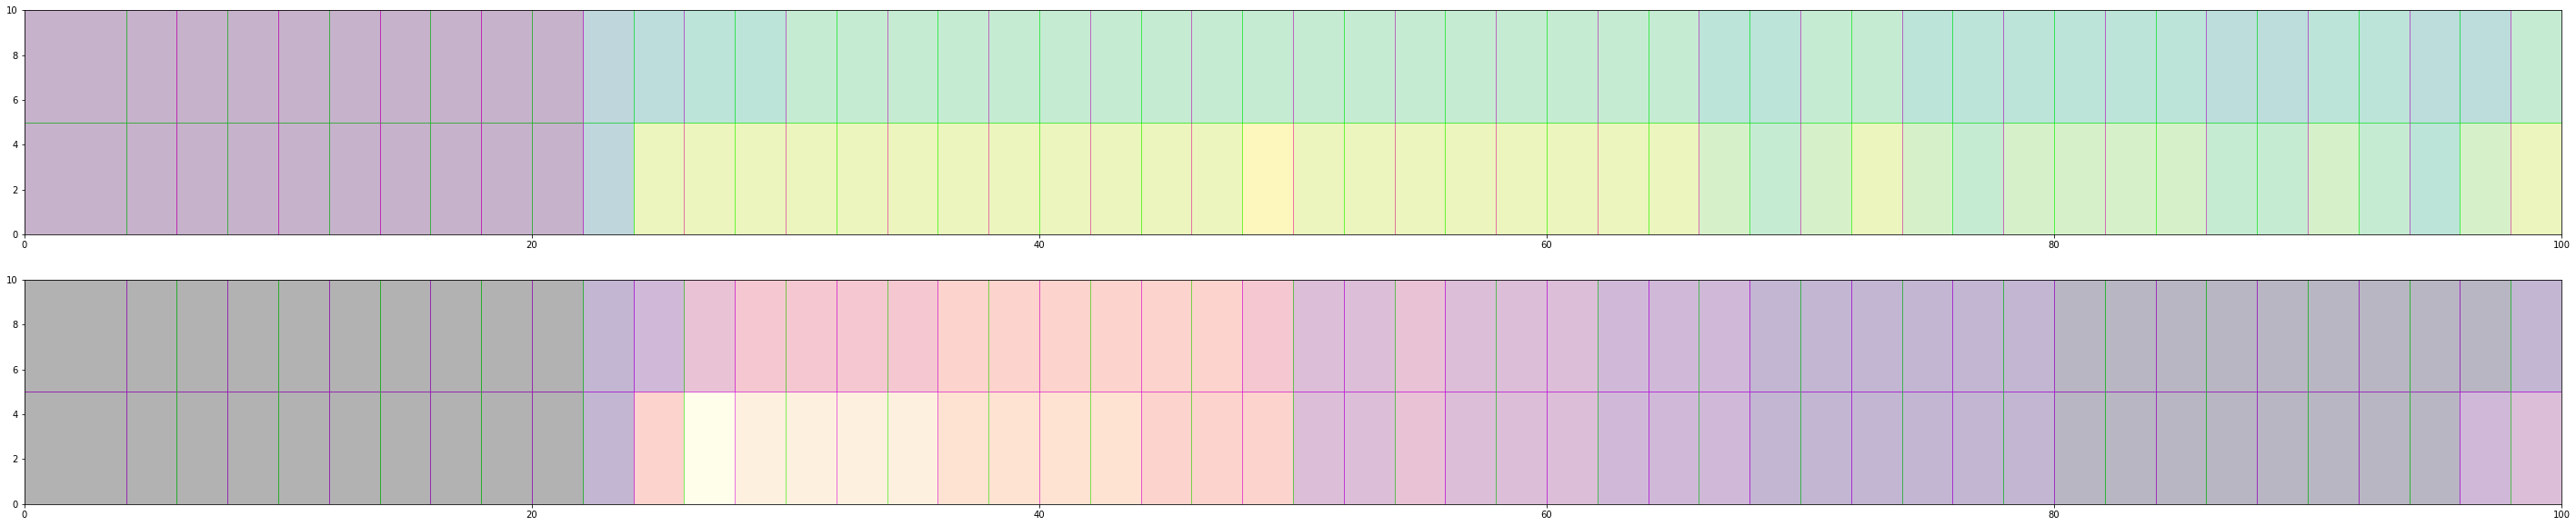

In [16]:
# Reset internal model values
ped.internal_model.reset_values()
ped.set_loc((25,0))
ped.set_internal_model_state_and_search_policy()

# Run updates and plot again
n_updates = 500
for i in range(n_updates):
	ped.mc_update_of_internal_model()
    

fig = plot_ped_feature_values(ped, figsize, nbins = 10, cmaps = ['viridis', 'magma'], alpha = 0.5, op = 'intersection')

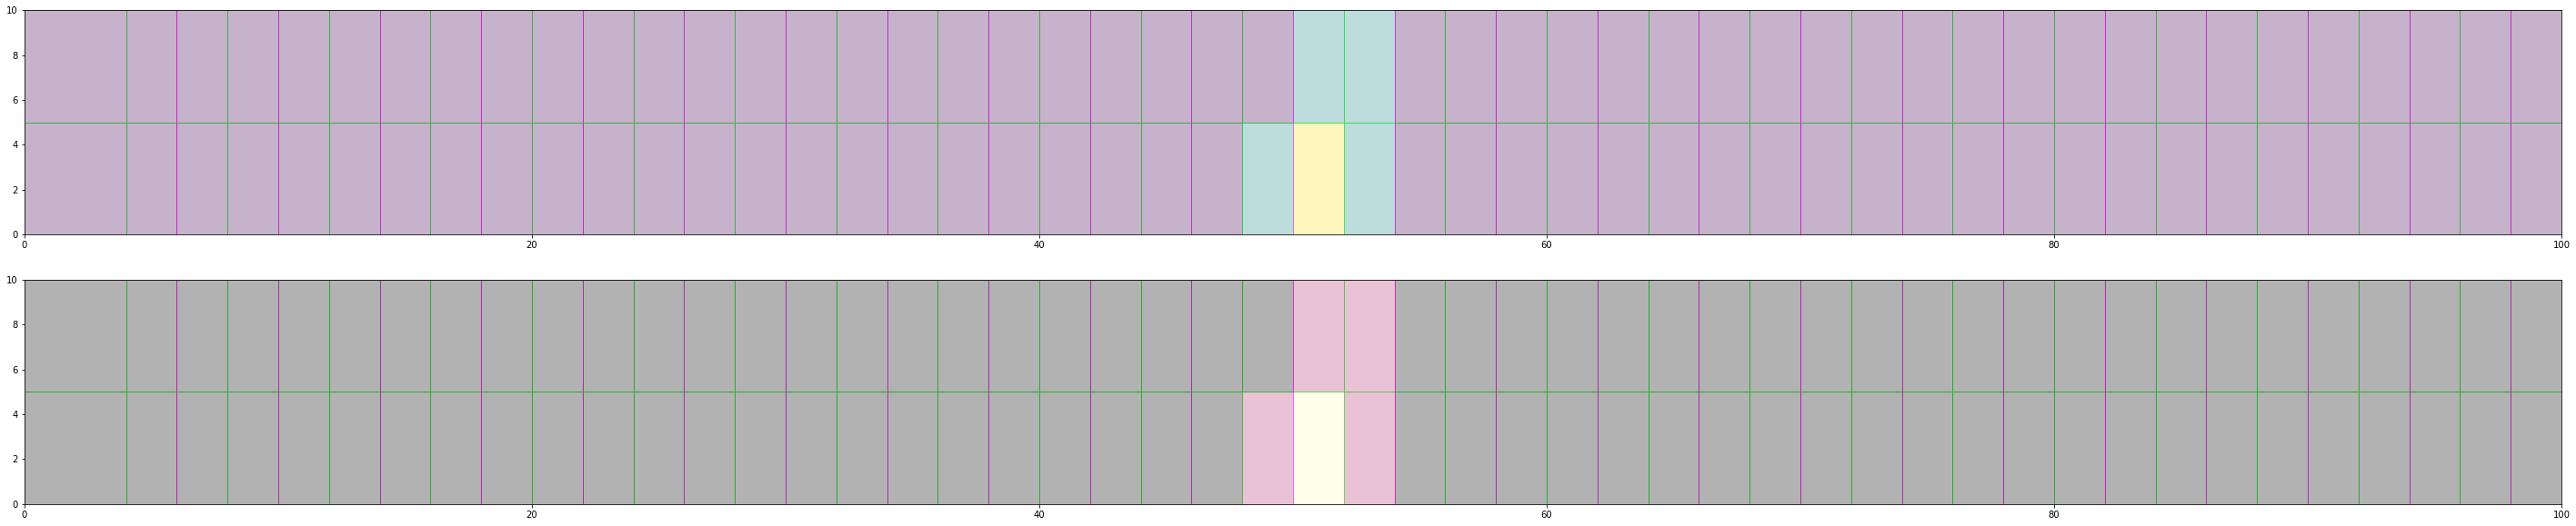

In [17]:
# Reset internal model values
ped.internal_model.reset_values()
ped.set_loc((50,0))
ped.set_internal_model_state_and_search_policy()

# Run updates and plot again
n_updates = 500
for i in range(n_updates):
	ped.mc_update_of_internal_model()
    

fig = plot_ped_feature_values(ped, figsize, nbins = 10, cmaps = ['viridis', 'magma'], alpha = 0.5, op = 'intersection')

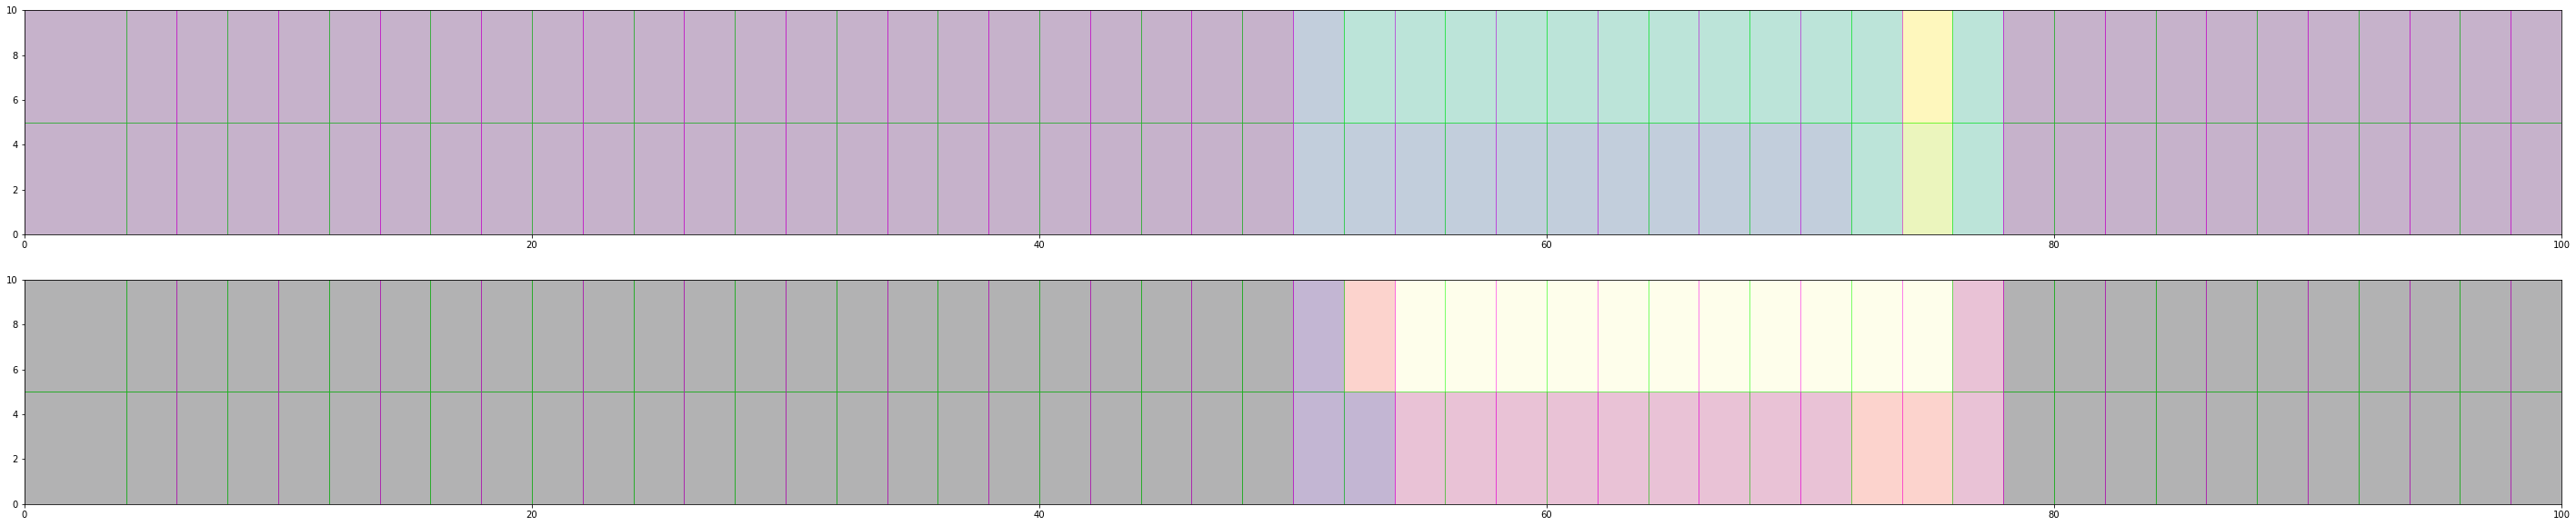

In [18]:
# Reset internal model values
ped.internal_model.reset_values()
ped.set_loc((75,0))
ped.set_internal_model_state_and_search_policy()

# Run updates and plot again
n_updates = 500
for i in range(n_updates):
	ped.mc_update_of_internal_model()
    

fig = plot_ped_feature_values(ped, figsize, nbins = 10, cmaps = ['viridis', 'magma'], alpha = 0.5, op = 'intersection')

## Trajectory if ped planned once at start only

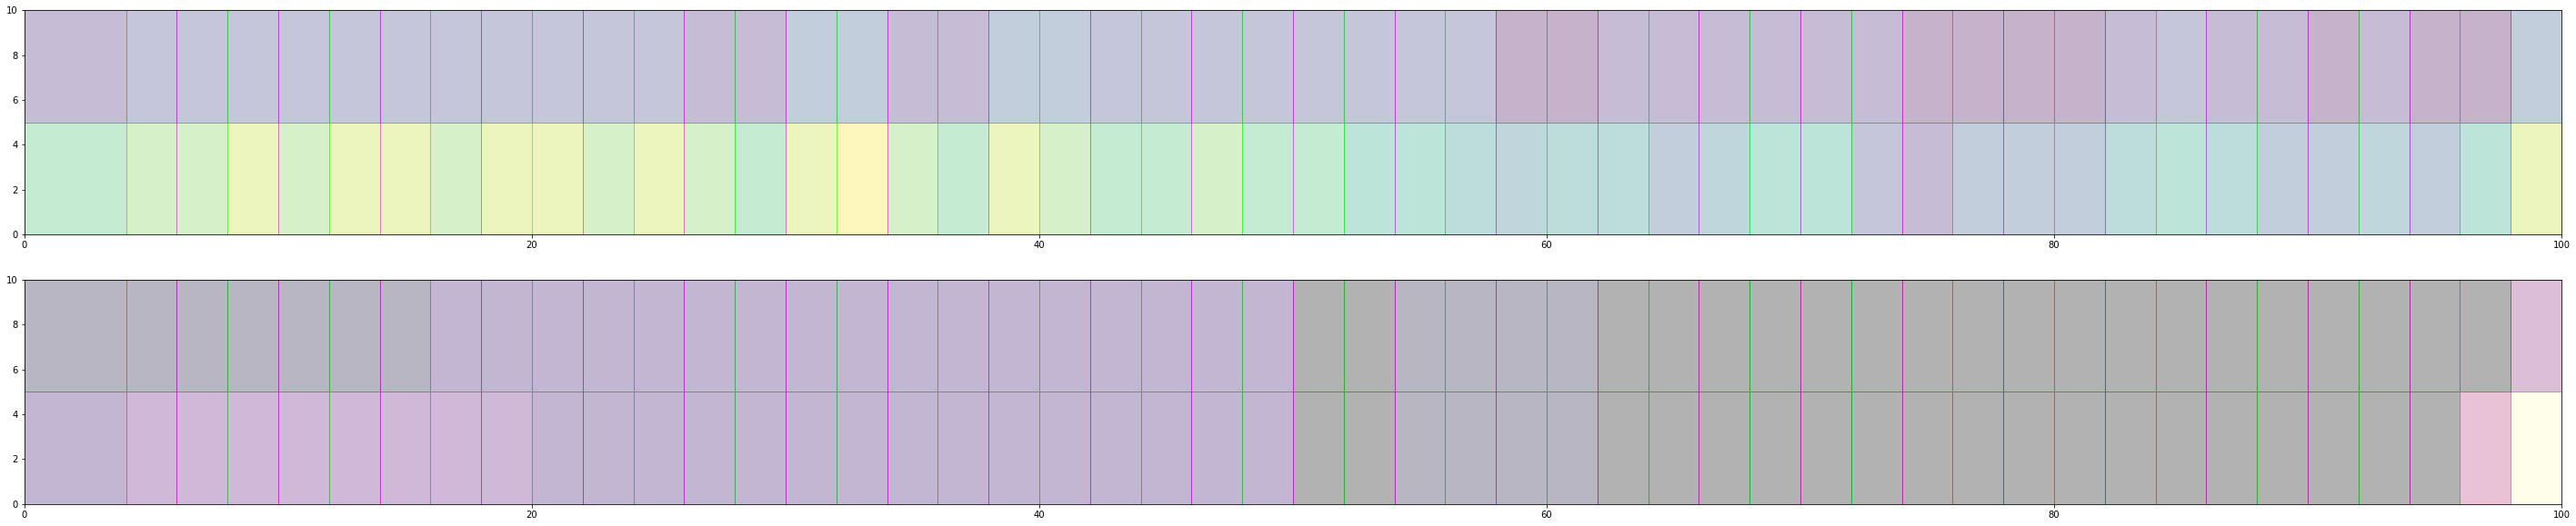

In [19]:
# Reset internal model values
ped.internal_model.reset_values()
ped.set_loc((0,0))
ped.set_internal_model_state_and_search_policy()
n_updates = 500
for i in range(n_updates):
	ped.mc_update_of_internal_model()

fig = plot_ped_feature_values(ped, figsize, nbins = 10, cmaps = ['viridis', 'magma'], alpha = 0.5, op = 'intersection')

In [20]:
i = 0
while (ped.internal_model.isTerminal() == False):
    ped.step(nupdates = 0)
    i+=1
    if (i > 500):
        break

In [21]:
for l in ped._loc_history:
    plot_state(l, fig=fig, color='red', markersize=12)

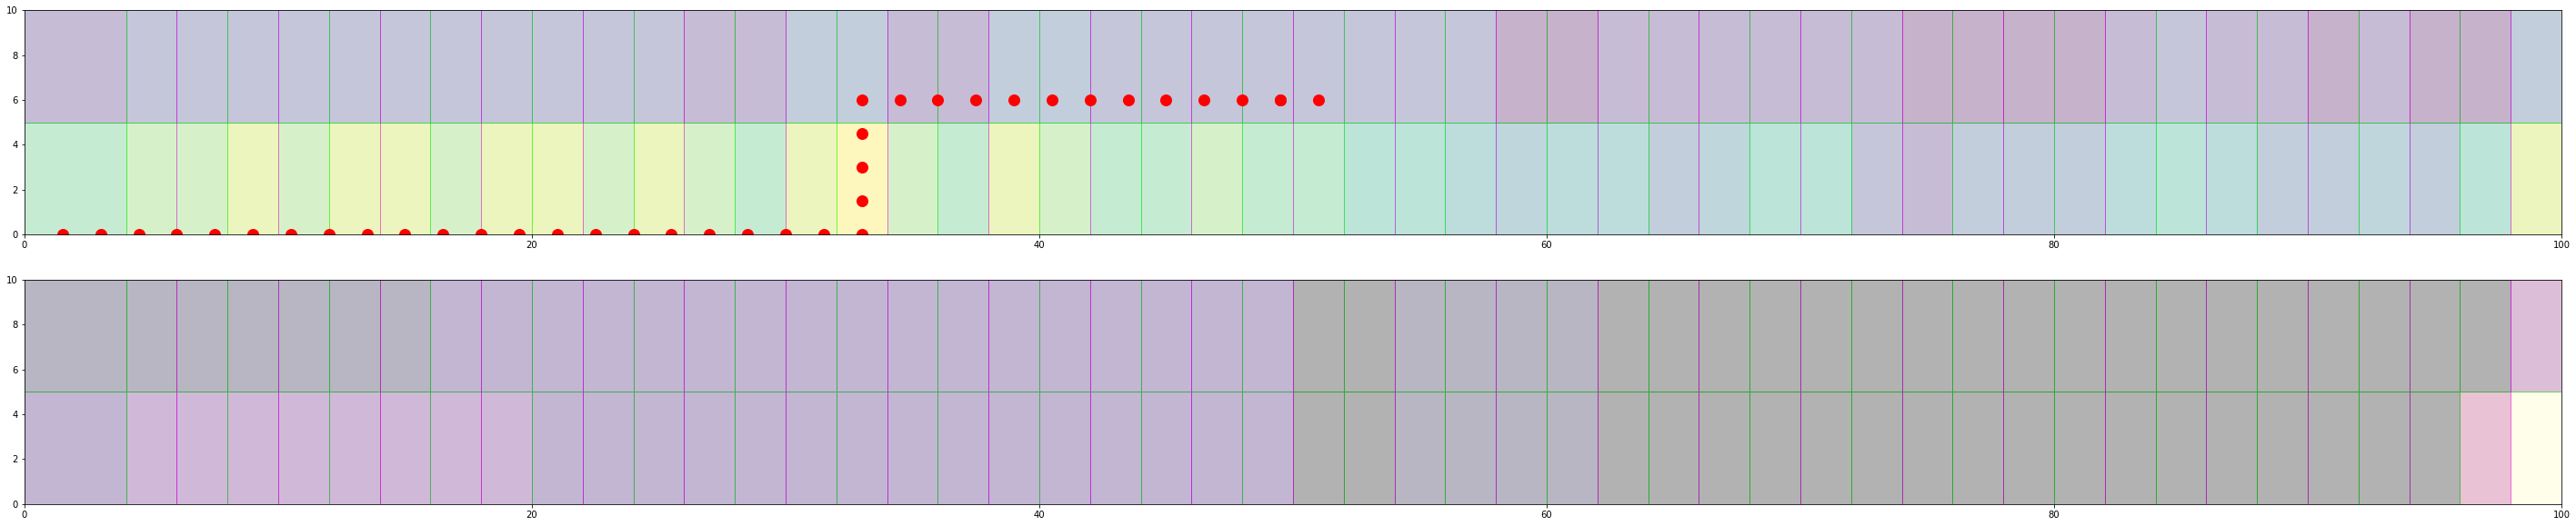

In [22]:
# Ped continues walking in a straigh line and past the edge of the road
fig

## Trajectory if ped planned while walking along

In [23]:
# Now repeat but allow the ped agent to update its value function as it walks along
# Reset internal model values
ped.internal_model.reset_values()
ped.set_loc((0,0))
ped.set_internal_model_state_and_search_policy()
i = 0
while (ped.internal_model.isTerminal() == False):
    ped.step(nupdates = 10)
    i+=1
    if (i > 500):
        break

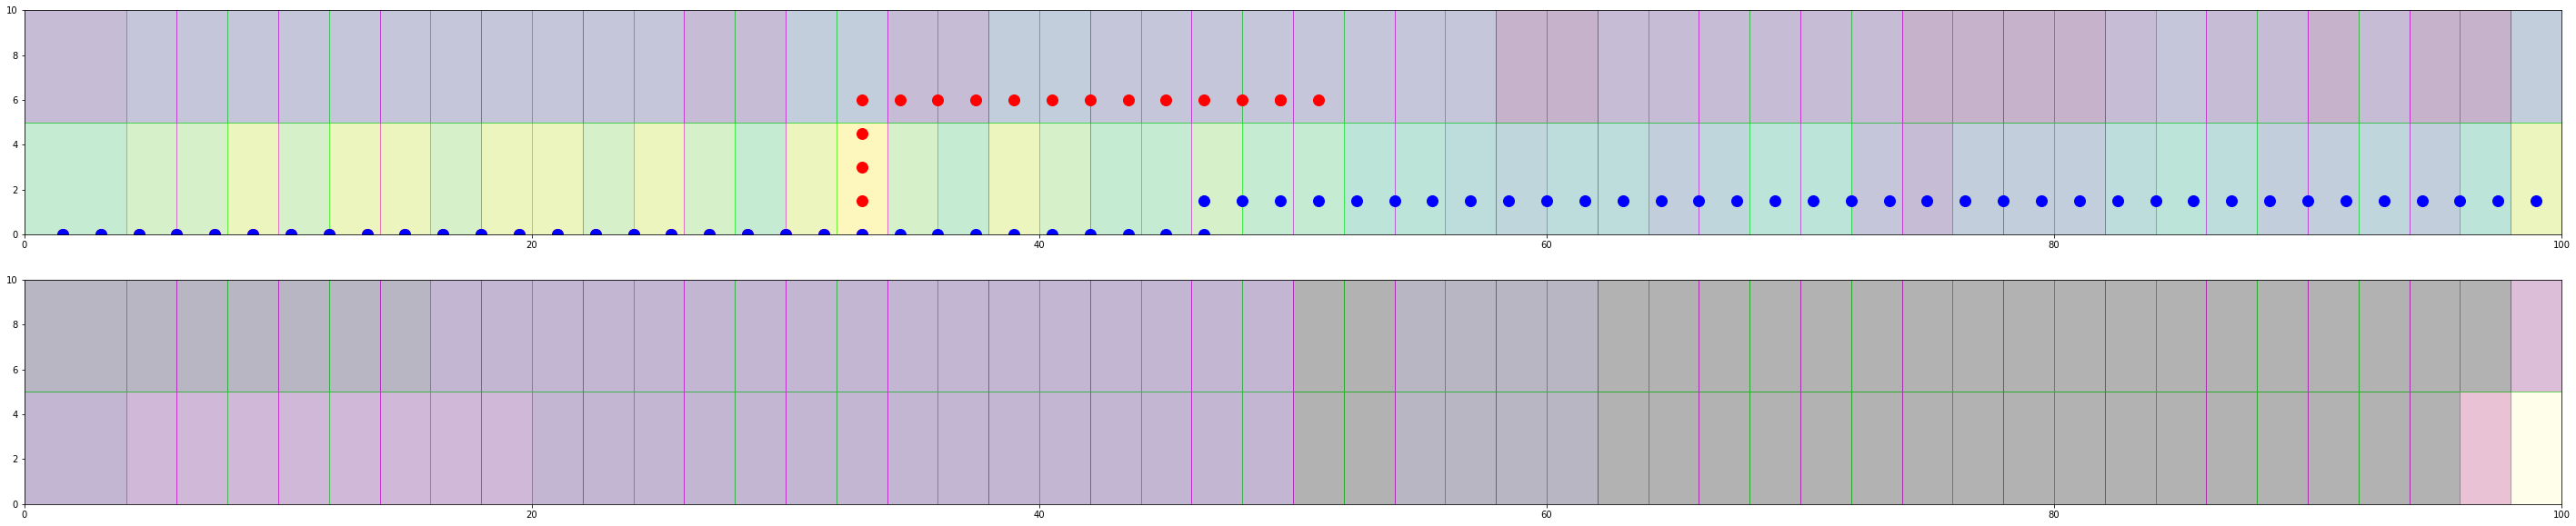

In [24]:
for l in ped._loc_history:
    plot_state(l, fig=fig, color='blue', markersize=12)
fig

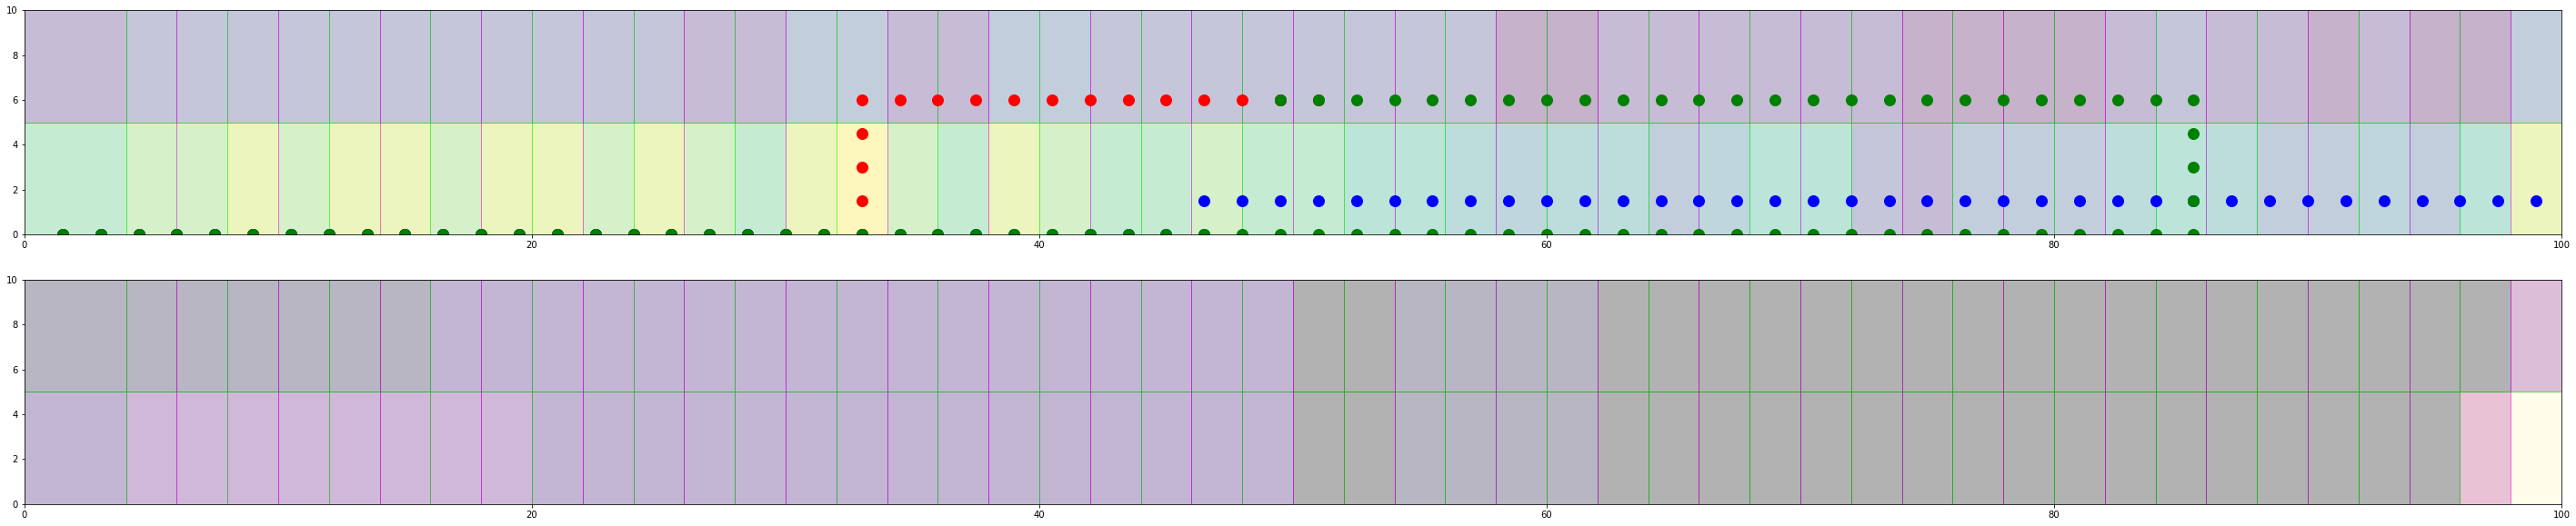

In [25]:
# Now repeat but allow the ped agent to update its value function as it walks along
# Reset internal model values
ped.internal_model.reset_values()
ped.set_loc((0,0))
ped.set_internal_model_state_and_search_policy()
i = 0
while (ped.internal_model.isTerminal() == False):
    ped.step(nupdates = 1)
    i+=1
    if (i > 500):
        break

for l in ped._loc_history:
    plot_state(l, fig=fig, color='green', markersize=12)
fig

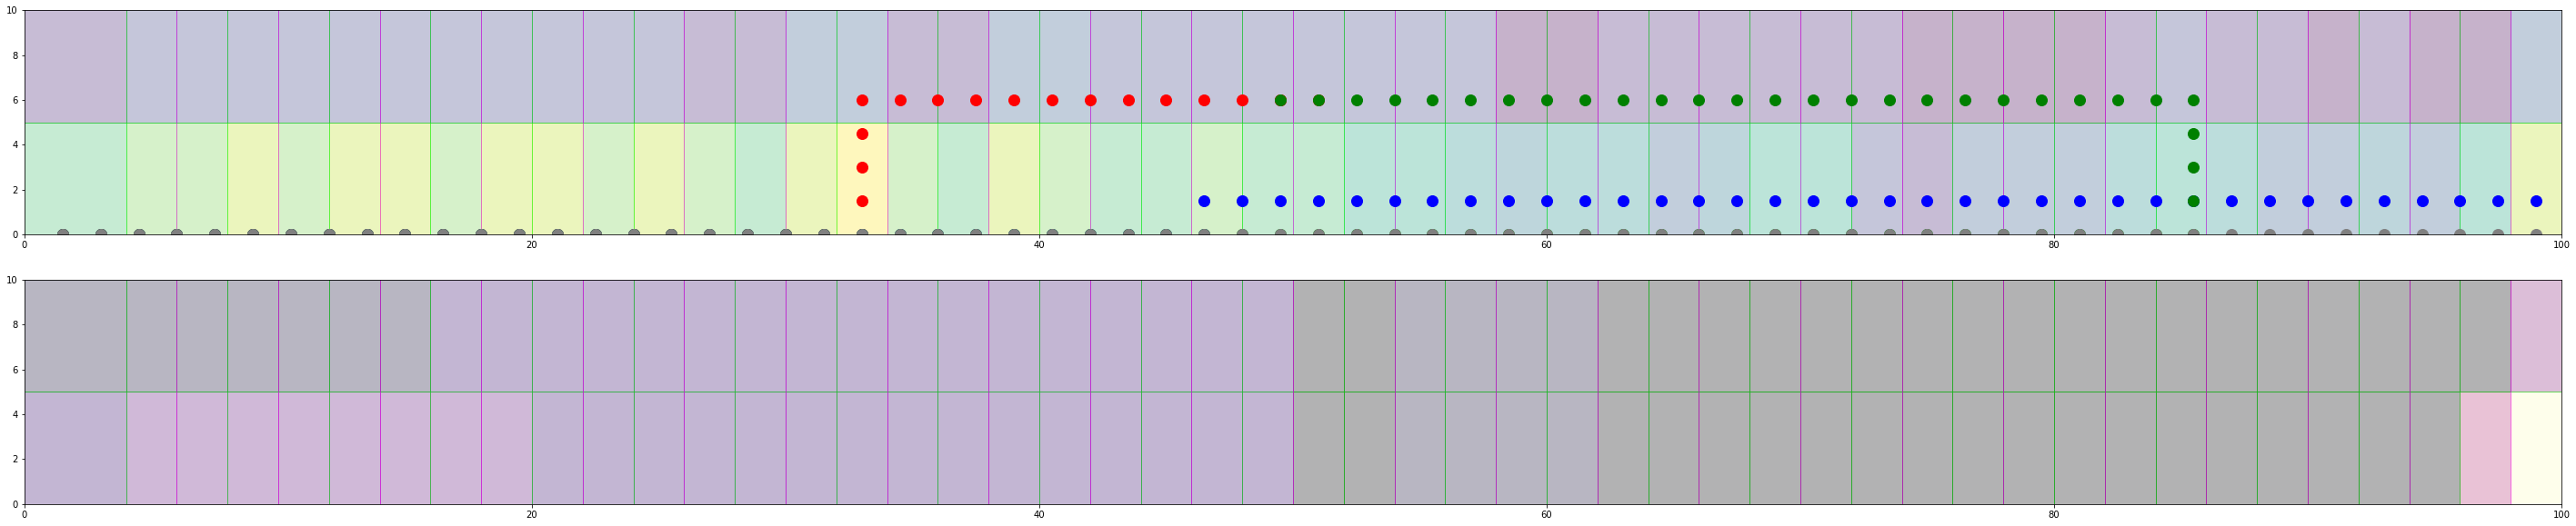

In [26]:
# Now repeat but allow the ped agent to update its value function as it walks along
# Reset internal model values
ped.internal_model.reset_values()
ped.set_loc((0,0))
ped.set_internal_model_state_and_search_policy()
i = 0
while (ped.internal_model.isTerminal() == False):
    ped.step(nupdates = 7)
    i+=1
    if (i > 500):
        break

for l in ped._loc_history:
    plot_state(l, fig=fig, color='grey', markersize=12)
fig